<a href="https://colab.research.google.com/github/czeacach/fashion_designers/blob/main/Distribution_nationalit%C3%A9s_fashiondesigners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploration des nationalités et de leur évolution dans le temps

Dans ce carnet est proposée une exploration des nationalités (city of citizenship) de la population Wikidata retenue.
On essayera de prendre connaissance des liens entre types de nationalités, genre et générations


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
!pip install itables

In [ ]:
from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [ ]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile

#Explorer les nationalités

In [ ]:
### Se connecter à la base de données dans laquelle on va insérer
# le résultat de la requête SPARQL
#chemin d'acces de la base de données directement connectée à l'ordinateur via Google Drive Desktop
'/content/drive/MyDrive/dossier de travail/fashion_designers_data_analysis.db'
cn = sql.connect('/content/drive/MyDrive/dossier de travail/fashion_designers_data_analysis.db')
cn

In [ ]:
### Le nombre de nationalités différents: noter qu'il y des répétitions
## et inconsistances dans les données de Wikidata

q="""
SELECT COUNT(*)
FROM wdt_nationality
"""
cur = cn.cursor()
r = cur.execute(q).fetchone()
print('Nombre de nationalités différentes:' , r[0])

Nombre de nationalités différentes: 164


In [ ]:
### Inspecter la table des nationalités Wikidata (wdt_nationality)

q="""
SELECT pk_nationality, nationalityLabel, nationalityUri
FROM wdt_nationality
"""
cur = cn.cursor()
r = cur.execute(q).fetchall()
[e for e in r][:3]

[(1, 'france', 'http://www.wikidata.org/entity/Q142'),
 (2, 'grand principality of finland', 'http://www.wikidata.org/entity/Q62633'),
 (3, 'sweden', 'http://www.wikidata.org/entity/Q34')]

In [ ]:
### Compter les occurrences de chaque nationalités
q="""
-- noter que la fonction TRIM élimine les éventuels espaces en début ou fin de chaine de charactères
-- la fonction LOWER met tout au minuscule
SELECT TRIM(nationalityUri) as nationalityUri, LOWER(TRIM(nationalityLabel)) AS nationalityLabel, COUNT(*) as effectif
FROM wdt_person_nationality
GROUP BY TRIM(nationalityUri), LOWER(TRIM(nationalityLabel))
ORDER BY effectif DESC
"""
cur = cn.cursor()
r = cur.execute(q).fetchall()
rdf = pd.DataFrame(r,columns=['uri', 'label', 'freq'])
rdf.head()

,uri,label,freq
0,http://www.wikidata.org/entity/Q30,united states of america,556
1,http://www.wikidata.org/entity/Q145,united kingdom,235
2,http://www.wikidata.org/entity/Q142,france,213
3,http://www.wikidata.org/entity/Q17,japan,163
4,http://www.wikidata.org/entity/Q38,italy,150


In [ ]:
rdf.tail()

,uri,label,freq
159,http://www.wikidata.org/entity/Q889,afghanistan,1
160,http://www.wikidata.org/entity/Q916,angola,1
161,http://www.wikidata.org/entity/Q945,togo,1
162,http://www.wikidata.org/entity/Q963,botswana,1
163,http://www.wikidata.org/entity/Q967,burundi,1


In [ ]:
q = """
-- La fonction TRIM élimine les éventuels espaces en début ou fin de chaîne de caractères
-- La fonction LOWER met tout en minuscule
SELECT
    TRIM(wpn.nationalityUri) AS nationalityUri,
    LOWER(TRIM(wpn.nationalityLabel)) AS nationalityLabel,
    SUM(CASE WHEN p.gender_person = 'female' THEN 1 ELSE 0 END) AS female,
    SUM(CASE WHEN p.gender_person = 'male' THEN 1 ELSE 0 END) AS male
FROM wdt_person_nationality wpn
JOIN person p ON wpn.personUri = p.uri_person
GROUP BY TRIM(wpn.nationalityUri), LOWER(TRIM(wpn.nationalityLabel))
ORDER BY female + male DESC
"""
cur = cn.cursor()
r = cur.execute(q).fetchall()

# Créer le DataFrame à partir des résultats de la requête
rdf = pd.DataFrame(r, columns=['uri', 'label', 'female', 'male'])
rdf.head()

,uri,label,female,male
0,http://www.wikidata.org/entity/Q30,united states of america,325,233
1,http://www.wikidata.org/entity/Q145,united kingdom,124,109
2,http://www.wikidata.org/entity/Q142,france,102,113
3,http://www.wikidata.org/entity/Q17,japan,75,80
4,http://www.wikidata.org/entity/Q38,italy,68,82


In [ ]:
### On observe une très grande dispersion: comment traiter ce problème?

rdf['freq'].describe()

count    164.000000
mean      19.298780
std       54.580068
min        1.000000
25%        1.000000
50%        3.000000
75%       13.250000
max      556.000000
Name: freq, dtype: float64

In [ ]:
### On transforme en DataFrame le résultat du regroupement par fréquence:
# combien de fois un certain nombre d'occurrences ?

q="""
WITH tw1 AS (
SELECT LOWER(TRIM(nationalityLabel)) nationalityLabel, COUNT(*) as effectif
FROM wdt_person_nationality
GROUP BY TRIM(nationalityUri), LOWER(TRIM(nationalityLabel)) )
SELECT effectif, count(*) as nombre_occ, group_concat(nationalityLabel, '; ')
FROM tw1
GROUP BY effectif
ORDER BY nombre_occ DESC, effectif ASC;
"""
cur = cn.cursor()
r = cur.execute(q).fetchall()

## La colonne 'occurrences' indique le nombre de mentions d'une nationalité,
# la colonne'nombre_occ' combien de nationalités ont cette occurrence
dfr = pd.DataFrame(r, columns=['occurrences','nombre_occ', 'labels_occ'])

# Par exemple, la première ligne indique qu'il y a 51 nationalités mentionnées une seule fois
dfr.head()

,occurrences,nombre_occ,labels_occ
0,1,51,the gambia; ivory coast; liberia; mauritius; n...
1,2,25,cameroon; kenya; ethiopia; republic of china; ...
2,4,14,german reich; german democratic republic; engl...
3,3,9,morocco; austrian empire; kingdom of yugoslavi...
4,14,5,united kingdom of great britain and ireland; g...


In [ ]:
### Les nationalités les plus fréquentes
dfr.tail()

,occurrences,nombre_occ,labels_occ
38,150,1,italy
39,163,1,japan
40,213,1,france
41,235,1,united kingdom
42,556,1,united states of america


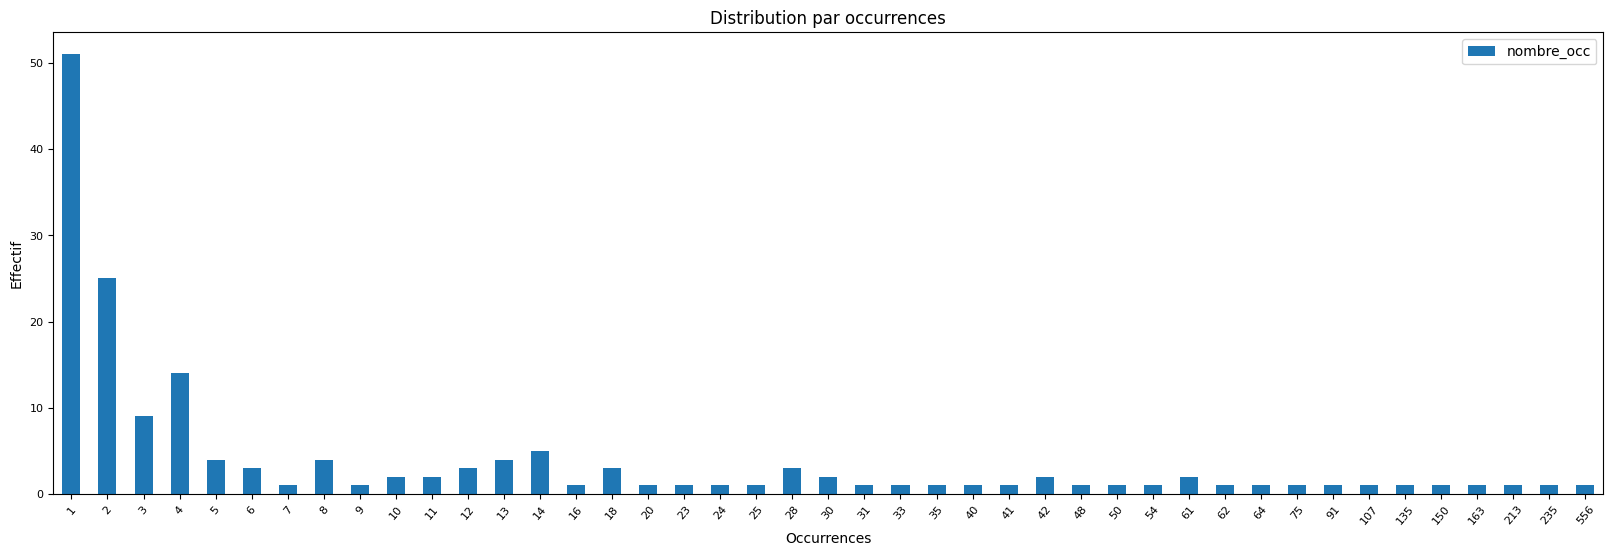

In [ ]:
### Représentation graphique des effectifs par occurrences

ax = dfr.sort_values(by='occurrences', ascending=True).plot(x='occurrences', y='nombre_occ',
                 kind='bar', fontsize=8, figsize=(20,6), rot=50) # ,rot=5


plt.ylabel('Effectif')
plt.xlabel('Occurrences')
plt.title('Distribution par occurrences')
plt.show()

In [ ]:
dfr['occ_qcut'] = pd.qcut(dfr['occurrences'], 10)
dfr['occ_qcut']  = dfr['occ_qcut'] .apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)))

dfr.head()

,occurrences,nombre_occ,labels_occ,occ_qcut
0,1,51,the gambia; ivory coast; liberia; mauritius; n...,0-5
1,2,25,cameroon; kenya; ethiopia; republic of china; ...,0-5
2,4,14,german reich; german democratic republic; engl...,0-5
3,3,9,morocco; austrian empire; kingdom of yugoslavi...,0-5
4,14,5,united kingdom of great britain and ireland; g...,13-22


In [ ]:
dfrg = dfr.groupby(by='occ_qcut', observed=True).sum(['occurrences','nombre_occ'])
dfrg

,occurrences,nombre_occ
occ_qcut,,
0-5,15,103
5-9,30,9
9-13,46,11
13-22,68,10
22-30,130,8
30-40,139,4
40-51,181,5
51-70,241,5
70-147,408,4


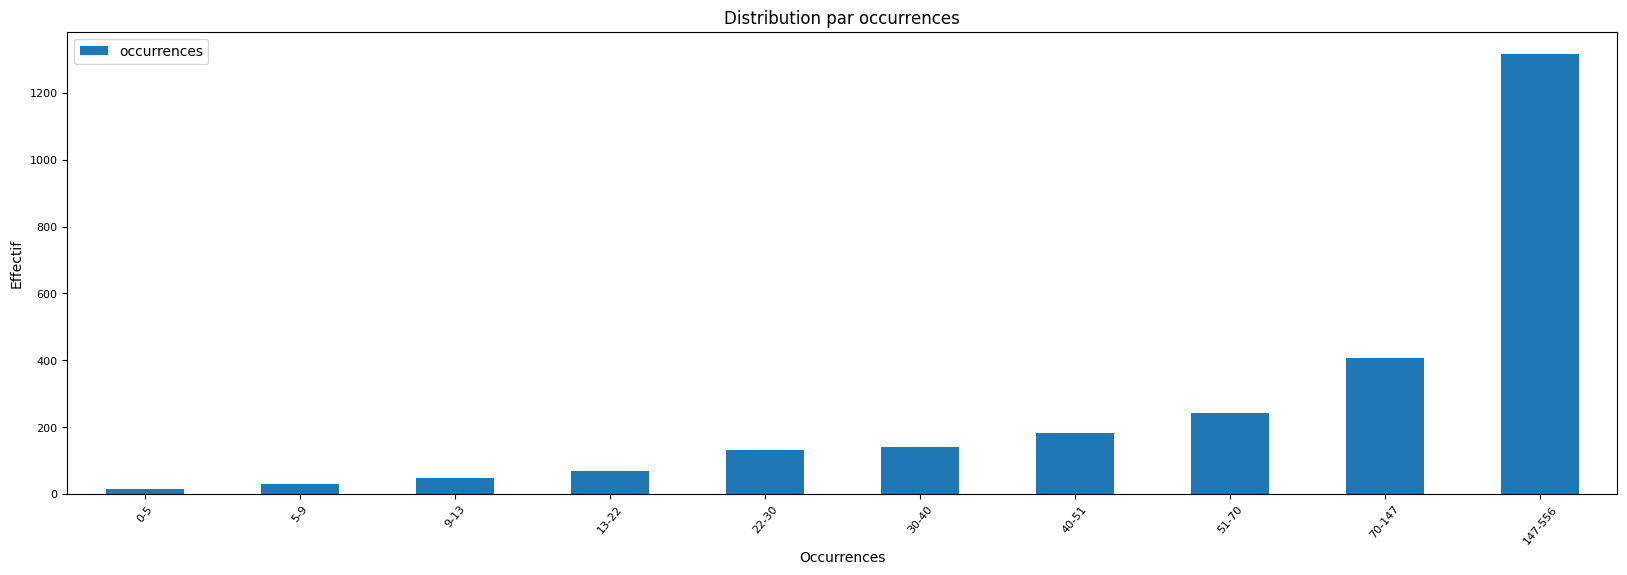

In [ ]:
### Représentation graphique des effectifs par occurrences

ax = dfrg.sort_values(by='occurrences', ascending=True).plot( y='occurrences',
                 kind='bar', fontsize=8, figsize=(20,6), rot=50) # ,rot=5


plt.ylabel('Effectif')
plt.xlabel('Occurrences')
plt.title('Distribution par occurrences')
plt.show()

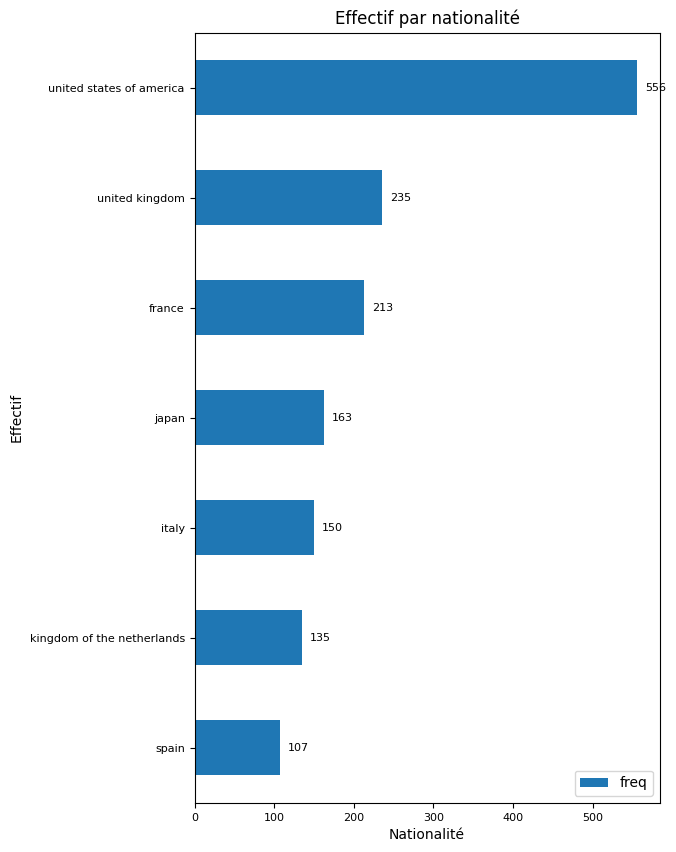

In [ ]:
### Représentation graphique des effectifs par nationalités

# ATTENTION : noter les filtres sur les effectifs
ax = rdf[(rdf['freq']>100) & (rdf['freq'] < 2001)].sort_values(by='freq', ascending=True).plot(x='label', y='freq',
                 kind='barh', fontsize=8, figsize=(6, 10)) # ,rot=5


#max_xticks = 20
#xloc = plt.MaxNLocator(max_xticks)
#ax.xaxis.set_major_locator(xloc)

x = rdf[(rdf['freq']>100) & (rdf['freq'] < 2000)]['freq'].sort_values(ascending=True).to_list()
for i, v in enumerate(x):
    ax.text(v + 10, i, str(v), color='black', fontsize=8, verticalalignment='center')


plt.ylabel('Effectif')
plt.xlabel('Nationalité')
plt.title('Effectif par nationalité')
plt.show()

# Explorer les personnes en relation avec leur(s) nationalité(s)

In [ ]:
### Créer la requête SQL et inspecter le résultat
# Noter les jointures entre les différentes tables
q = """
SELECT wp.personUri, wp.personLabel, min(wp.genderUri) gender,
            min(wp.birthYear) birthYear,
            group_concat(distinct trim(nationalityLabel)) nationalityLabels
FROM wdt_person_nationality wpo
JOIN wdt_personne wp ON wp.personUri = wpo.personUri
GROUP BY wp.personUri, wp.personLabel;
"""
cur = cn.cursor()
r = cur.execute(q).fetchall()
[e for e in r][:3]

[('http://www.wikidata.org/entity/Q100324415',
  'Estrella Rivas Franco',
  'http://www.wikidata.org/entity/Q6581072',
  '1921',
  'Spain'),
 ('http://www.wikidata.org/entity/Q100462257',
  'Ina Trifonova',
  'http://www.wikidata.org/entity/Q6581072',
  '1981',
  'Bulgaria'),
 ('http://www.wikidata.org/entity/Q101085725',
  'Abbas Kaijuka',
  'http://www.wikidata.org/entity/Q6581097',
  '1989',
  'Uganda')]

In [ ]:
### Créer la requête SQL et inspecter le résultat
# Noter les jointures entre les différentes tables
q = """
SELECT
    wp.personUri,
    wp.personLabel,
    min(wp.genderUri) gender,
    min(wp.birthYear) birthYear,
    group_concat(distinct trim(wn.nationalityLabel)) nationalityLabels,
    group_concat(distinct trim(continentLabel)) continentLabels
FROM
    wdt_person_nationality wpo
JOIN
    wdt_personne wp ON wp.personUri = wpo.personUri
JOIN
    wdt_nationality wn ON wpo.nationalityUri = wn.nationalityUri
JOIN
    continents wc ON wn.fk_continent = wc.pk_continent
GROUP BY
    wp.personUri, wp.personLabel;
    """
cur = cn.cursor()
r = cur.execute(q).fetchall()
[e for e in r][:3]

[('http://www.wikidata.org/entity/Q100324415',
  'Estrella Rivas Franco',
  'http://www.wikidata.org/entity/Q6581072',
  '1921',
  'spain',
  'Europe'),
 ('http://www.wikidata.org/entity/Q100462257',
  'Ina Trifonova',
  'http://www.wikidata.org/entity/Q6581072',
  '1981',
  'bulgaria',
  'Europe'),
 ('http://www.wikidata.org/entity/Q101085725',
  'Abbas Kaijuka',
  'http://www.wikidata.org/entity/Q6581097',
  '1989',
  'uganda',
  'Africa')]

#Créer le tableau à analyser

In [ ]:
### On transforme la liste en DataFrame

df_p = pd.DataFrame(r, columns=['person_uri', 'person_label',
                        'genderUri', 'birthYear', 'nationalités', 'continents'])
df_p = df_p.set_index('person_uri',drop=True)


### On ajoute une nouvelle colonne avec les nationalités sous forme de liste
df_p['l_nationalités'] = df_p.apply(lambda x: x['nationalités'].split(','), axis=1)

### On ajoute une nouvelle colonne avec les continents sous forme de liste
df_p['l_continents'] = df_p.apply(lambda x: x['continents'].split(','), axis=1)

### On ajoute une nouvelle colonne avec le nombre de composantes de la liste
df_p['length_l_occ'] = df_p.apply(lambda x: len(x['l_nationalités']), axis=1)

### On ajoute une nouvelle colonne avec le nombre de composantes de la liste
df_p['length_l_occ'] = df_p.apply(lambda x: len(x['l_continents']), axis=1)

## on pourrait éliminer la colonne originale
# mais on la laisse car utile pour les filtres
## df_p = df_p.drop(columns=['occupations'])

df_p.head()

,person_label,genderUri,birthYear,nationalités,continents,l_nationalités,l_continents,length_l_occ
person_uri,,,,,,,,
http://www.wikidata.org/entity/Q100324415,Estrella Rivas Franco,http://www.wikidata.org/entity/Q6581072,1921,spain,Europe,[spain],[Europe],1
http://www.wikidata.org/entity/Q100462257,Ina Trifonova,http://www.wikidata.org/entity/Q6581072,1981,bulgaria,Europe,[bulgaria],[Europe],1
http://www.wikidata.org/entity/Q101085725,Abbas Kaijuka,http://www.wikidata.org/entity/Q6581097,1989,uganda,Africa,[uganda],[Africa],1
http://www.wikidata.org/entity/Q101611457,Dennis Klaverweide,http://www.wikidata.org/entity/Q6581097,1990,kingdom of the netherlands,Europe,[kingdom of the netherlands],[Europe],1
http://www.wikidata.org/entity/Q101627961,Sepehr Maghsoudi,http://www.wikidata.org/entity/Q6581097,1982,kingdom of the netherlands,Europe,[kingdom of the netherlands],[Europe],1


In [ ]:
# nombre d'instances = lignes du dataframe
print(len(df_p))


2856


## Coder le genre

In [ ]:
### On créé d'abord une fonction qui effectue le travail

## l'argument de la fonction 'g_uri' est un nom choisi librement
# il est ensuite appelé dans la fonction comme variable
# et contient la valeur introduite lors de l'utilisation de la fonction
def code_gender(g_uri):
    if g_uri == 'http://www.wikidata.org/entity/Q6581097':
        # genre masculin
        a = 'M'
    elif g_uri =='http://www.wikidata.org/entity/Q6581072':
        # genre féminin
        a = 'F'
    else:
        # genre autre
        a = 'A'
    return a

In [ ]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p['gender'] = df_p.apply(lambda x: code_gender(x['genderUri']), axis=1)

## on élimine la colonne originale
df_p = df_p.drop(columns=['genderUri'])
### On inspecte les cinq premières lignes qui ont la valeur 'A' = autre
df_p[df_p['gender']=='A'][:5]

,person_label,birthYear,nationalités,continents,l_nationalités,l_continents,length_l_occ,gender
person_uri,,,,,,,,
http://www.wikidata.org/entity/Q107910513,Kataluna Enriquez,1995,united states of america,North America,[united states of america],[North America],1,A
http://www.wikidata.org/entity/Q116025164,Patricia Ramírez,1981,argentina,South America,[argentina],[South America],1,A
http://www.wikidata.org/entity/Q118730875,Chaoko,1997,spain,Europe,[spain],[Europe],1,A
http://www.wikidata.org/entity/Q121887025,Robertina Manganaro,1958,italy,Europe,[italy],[Europe],1,A
http://www.wikidata.org/entity/Q12501502,Asha Smara Darra,1977,indonesia,Asia,[indonesia],[Asia],1,A


In [ ]:
### Effectifs par genre
df_p.groupby(by='gender', observed=True).size()

gender
A      16
F    1586
M    1254
dtype: int64

## Ajouter les périodes

In [ ]:
# transformer l'année en entier
df_p['birthYear'] = df_p['birthYear'].astype(int)
# limiter aux personnes nées avant le 21e siècle
df_p = df_p[df_p['birthYear'] < 2001].copy(deep=True)
# vérifier année minimale et maximale
print(min(df_p['birthYear']),max(df_p['birthYear']))

1801 2000


In [ ]:
### Créer neuf périodes
l_per = [1801, 1826, 1851, 1876, 1901, 1926, 1951, 1976, 2001]

In [ ]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['periodes'] = pd.cut(df_p['birthYear'], l_per, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periodes'] = df_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,person_label,birthYear,nationalités,continents,l_nationalités,l_continents,length_l_occ,gender,periodes
person_uri,,,,,,,,,
http://www.wikidata.org/entity/Q100324415,Estrella Rivas Franco,1921,spain,Europe,[spain],[Europe],1,F,1901-1925
http://www.wikidata.org/entity/Q100462257,Ina Trifonova,1981,bulgaria,Europe,[bulgaria],[Europe],1,F,1976-2000
http://www.wikidata.org/entity/Q101085725,Abbas Kaijuka,1989,uganda,Africa,[uganda],[Africa],1,M,1976-2000


In [ ]:
### Effectifs par période
df_p.groupby(by='periodes', observed=True).size()

periodes
1801-1825      11
1826-1850       9
1851-1875      42
1876-1900     132
1901-1925     267
1926-1950     520
1951-1975    1009
1976-2000     866
dtype: int64

##  Ajout des colonnes "first nationality" et "first continent"
Pour pouvoir réaliser le tableau de contingence --> nécessité de choisir une seule nationalité

In [ ]:
# Sélectionner le premier élément de chaque liste dans la colonne 'l_continents'
first_continent = df_p['l_continents'].str[0]

# Créer un nouveau DataFrame avec la première nationalité uniquement
df_p_first_continent = df_p.copy()  # Faire une copie du DataFrame original
df_p_first_continent['first_continent'] = first_continent  # Ajouter la colonne 'first_continent'

# Supprimer la colonne 'l_nationalités' si nécessaire
# df_p_first_nationality = df_p_first_nationality.drop(columns=['l_nationalités'])

# Inspection
df_p_first_continent.tail()

,person_label,birthYear,nationalités,continents,l_nationalités,l_continents,length_l_occ,gender,periodes,first_continent
person_uri,,,,,,,,,,
http://www.wikidata.org/entity/Q99478791,Iveta Karklina-Viksne,1970,latvia,Europe,[latvia],[Europe],1,F,1951-1975,Europe
http://www.wikidata.org/entity/Q99529091,Nelson Enwerem,1995,nigeria,Africa,[nigeria],[Africa],1,M,1976-2000,Africa
http://www.wikidata.org/entity/Q99572935,Adejoke Lasisi,1986,nigeria,Africa,[nigeria],[Africa],1,F,1976-2000,Africa
http://www.wikidata.org/entity/Q99578171,Gerhard Weber,1941,germany,Europe,[germany],[Europe],1,M,1926-1950,Europe
http://www.wikidata.org/entity/Q99615223,Yemi Osunkoya,1969,nigeria,Africa,[nigeria],[Africa],1,M,1951-1975,Africa


# Périodes et continent de nationalités

## Tableau de contingence

In [ ]:
### La fonction pivot_table produit un tableau de contingence
## Au centre du tableau se trouvent les effectifs conjoints,
## aux bords les effectifs marginaux qui correspondent
## aux distributions indépendantes des variables

X = "first_continent"  # "0"
Y = "periodes"

c_obs_continents_periodes = df_p_first_continent[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
c_obs_continents_periodes

first_continent,Africa,Asia,Europe,North America,Oceania,South America,Total
periodes,,,,,,,
1801-1825,0,0,9,2,0,0,11
1826-1850,0,0,8,1,0,0,9
1851-1875,0,0,39,2,1,0,42
1876-1900,0,2,89,38,1,2,132
1901-1925,2,17,152,71,8,17,267
1926-1950,5,74,312,88,16,25,520
1951-1975,25,155,536,192,34,67,1009
1976-2000,74,151,379,190,18,54,866
Total,106,399,1524,584,78,165,2856


In [ ]:
### Fréquence conjointe et fréquence marginale (proportion par rapport au total)

c_obs_continents_periodes = np.round(c_obs_continents_periodes*100/c_obs_continents_periodes.iloc[-1,-1],1)
c_obs_continents_periodes

first_continent,Africa,Asia,Europe,North America,Oceania,South America,Total
periodes,,,,,,,
1801-1825,0.0,0.0,0.3,0.1,0.0,0.0,0.4
1826-1850,0.0,0.0,0.3,0.0,0.0,0.0,0.3
1851-1875,0.0,0.0,1.4,0.1,0.0,0.0,1.5
1876-1900,0.0,0.1,3.1,1.3,0.0,0.1,4.6
1901-1925,0.1,0.6,5.3,2.5,0.3,0.6,9.3
1926-1950,0.2,2.6,10.9,3.1,0.6,0.9,18.2
1951-1975,0.9,5.4,18.8,6.7,1.2,2.3,35.3
1976-2000,2.6,5.3,13.3,6.7,0.6,1.9,30.3
Total,3.7,14.0,53.4,20.4,2.7,5.8,100.0


In [ ]:
## Affichier par fréquences ( sur 1 = 100%)

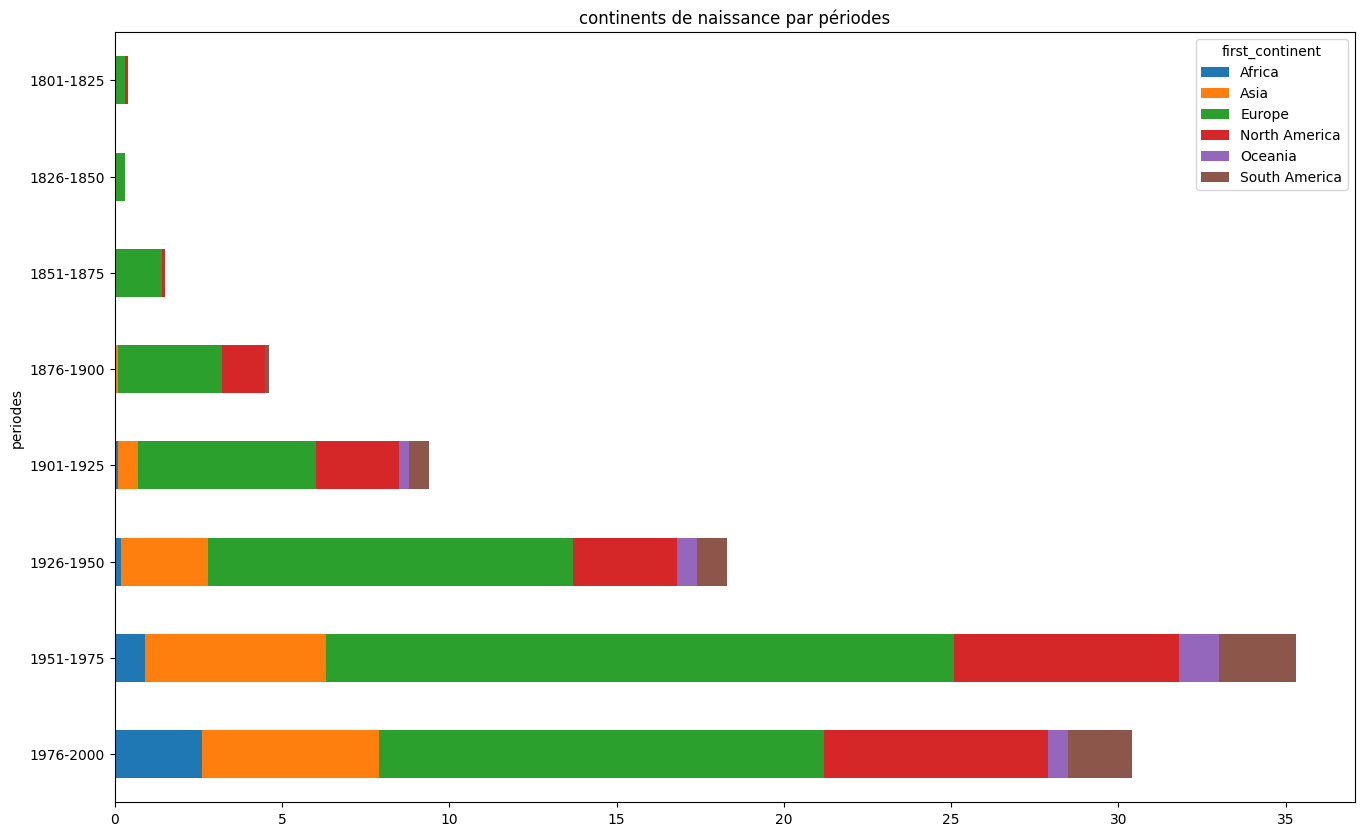

In [ ]:
### Effectifs des continents par périodes
g = c_obs_continents_periodes.iloc[:-1, :-1].sort_index(ascending=False)\
        .plot( kind='barh', stacked=True,  figsize=(16,10),  title = 'continents de naissance par périodes')

In [ ]:
### pourcentages des lignes
stacked_data_lignes = c_obs_continents_periodes.apply(lambda x: (x*100/sum(x)*2).round(2), axis=1) # axis=0
stacked_data_lignes

first_continent,Africa,Asia,Europe,North America,Oceania,South America,Total
periodes,,,,,,,
1801-1825,0.00,0.00,75.00,25.00,0.00,0.00,100.00
1826-1850,0.00,0.00,100.00,0.00,0.00,0.00,100.00
1851-1875,0.00,0.00,93.33,6.67,0.00,0.00,100.00
1876-1900,0.00,2.17,67.39,28.26,0.00,2.17,100.00
1901-1925,1.07,6.42,56.68,26.74,3.21,6.42,99.47
1926-1950,1.10,14.25,59.73,16.99,3.29,4.93,99.73
1951-1975,2.55,15.30,53.26,18.98,3.40,6.52,100.00
1976-2000,8.57,17.46,43.82,22.08,1.98,6.26,99.84
Total,3.70,14.00,53.40,20.40,2.70,5.80,100.00


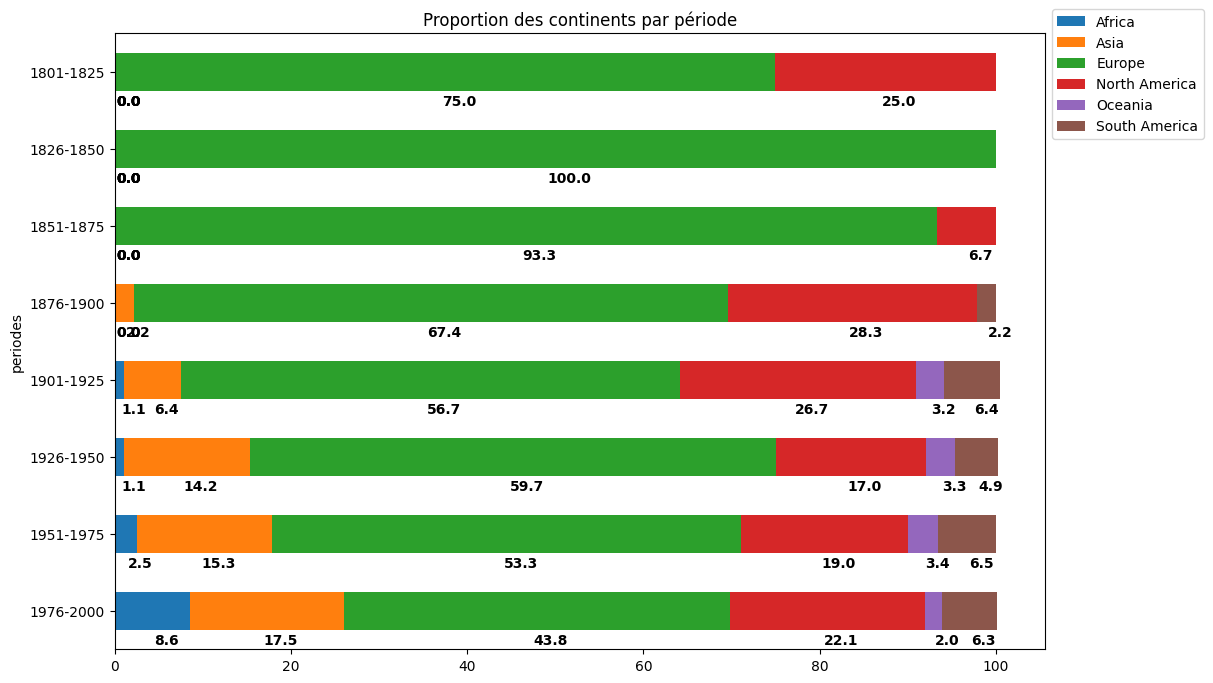

In [ ]:
### https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

z = stacked_data_lignes.iloc[:-1, :-1].sort_index(ascending=False).plot(kind="barh", stacked=True, figsize=(12,8), title='Proportion des continents par période')

### https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
#b = [(p.get_bbox().bounds, p.get_bbox().xmin,p.get_bbox().ymin, p.get_bbox().ymax, p.get_width(), p.get_y(), p.get_height()) for p in z.patches][59]
#print(b)
for p in z.patches:
    b = p.get_bbox()
    y_value=b.y1-b.y0
    z.annotate(format(p.get_width(), '.1f'),
                   (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()),
                   ha = 'center', va = 'center',
                   size=10,
                   # style = 'italic',
                   weight='bold',
                   color = 'black',
                   xytext = (10, -35),
                   textcoords = 'offset points')
z.legend(bbox_to_anchor=(1, 1.05))


# Distribution des continents de naissance dans le temps

In [ ]:
### Regrouper et compter avec un fitre sur le continent Europe
continent_e = pd.DataFrame(df_p_first_continent[df_p_first_continent.first_continent == 'Europe'].groupby('periodes').size())
continent_e.columns = ['Europe']
continent_e.tail()



,Europe
periodes,
1876-1900,89
1901-1925,152
1926-1950,312
1951-1975,536
1976-2000,379


In [ ]:
### Regrouper et compter avec un fitre sur le continent Afrique
continent_af = pd.DataFrame(df_p_first_continent[df_p_first_continent.first_continent == 'Africa'].groupby('periodes').size())
continent_af.columns = ['Africa']
continent_af.tail()


,Africa
periodes,
1876-1900,0
1901-1925,2
1926-1950,5
1951-1975,25
1976-2000,74


In [ ]:
### Regrouper et compter avec un fitre sur le continent Afrique
continent_as = pd.DataFrame(df_p_first_continent[df_p_first_continent.first_continent == 'Asia'].groupby('periodes').size())
continent_as.columns = ['Asia']
continent_as.tail()


,Asia
periodes,
1876-1900,2
1901-1925,17
1926-1950,74
1951-1975,155
1976-2000,151


In [ ]:
### Regrouper et compter avec un fitre sur le continent Océanie
continent_o = pd.DataFrame(df_p_first_continent[df_p_first_continent.first_continent == 'Oceania'].groupby('periodes').size())
continent_o.columns = ['Oceania']
continent_o.tail()

,Oceania
periodes,
1876-1900,1
1901-1925,8
1926-1950,16
1951-1975,34
1976-2000,18


In [ ]:
### Regrouper et compter avec un fitre sur le continent Amérique du Nord
continent_na = pd.DataFrame(df_p_first_continent[df_p_first_continent.first_continent == 'North America'].groupby('periodes').size())
continent_na.columns = ['North America']
continent_na.tail()

,North America
periodes,
1876-1900,38
1901-1925,71
1926-1950,88
1951-1975,192
1976-2000,190


In [ ]:
### Regrouper et compter avec un fitre sur le continent Amérique du Sud
continent_sa = pd.DataFrame(df_p_first_continent[df_p_first_continent.first_continent == 'South America'].groupby('periodes').size())
continent_sa.columns = ['South America']
continent_sa.tail()

,South America
periodes,
1876-1900,2
1901-1925,17
1926-1950,25
1951-1975,67
1976-2000,54


In [ ]:
dfs = [continent_e, continent_af, continent_as, continent_o, continent_na, continent_sa]
# Fusionner les DataFrames en utilisant l'index comme clé de jointure
merged = pd.merge(dfs[0], dfs[1], left_index=True, right_index=True)  # Utilisation des deux premiers DataFrames pour commencer la fusion

# Fusionner les DataFrames restants un par un
for df in dfs[2:]:
    merged = pd.merge(merged, df, left_index=True, right_index=True)
merged.tail()

,Europe,Africa,Asia,Oceania,North America,South America
periodes,,,,,,
1876-1900,89,0,2,1,38,2
1901-1925,152,2,17,8,71,17
1926-1950,312,5,74,16,88,25
1951-1975,536,25,155,34,192,67
1976-2000,379,74,151,18,190,54


In [ ]:
### Transformer l'index de séquence à chaîne de caractères
# ce qui est indispensable pour l'affichage dans un graphique
merged.index = merged.index.map(str)
merged.tail()

,Europe,Africa,Asia,Oceania,North America,South America
periodes,,,,,,
1876-1900,89,0,2,1,38,2
1901-1925,152,2,17,8,71,17
1926-1950,312,5,74,16,88,25
1951-1975,536,25,155,34,192,67
1976-2000,379,74,151,18,190,54


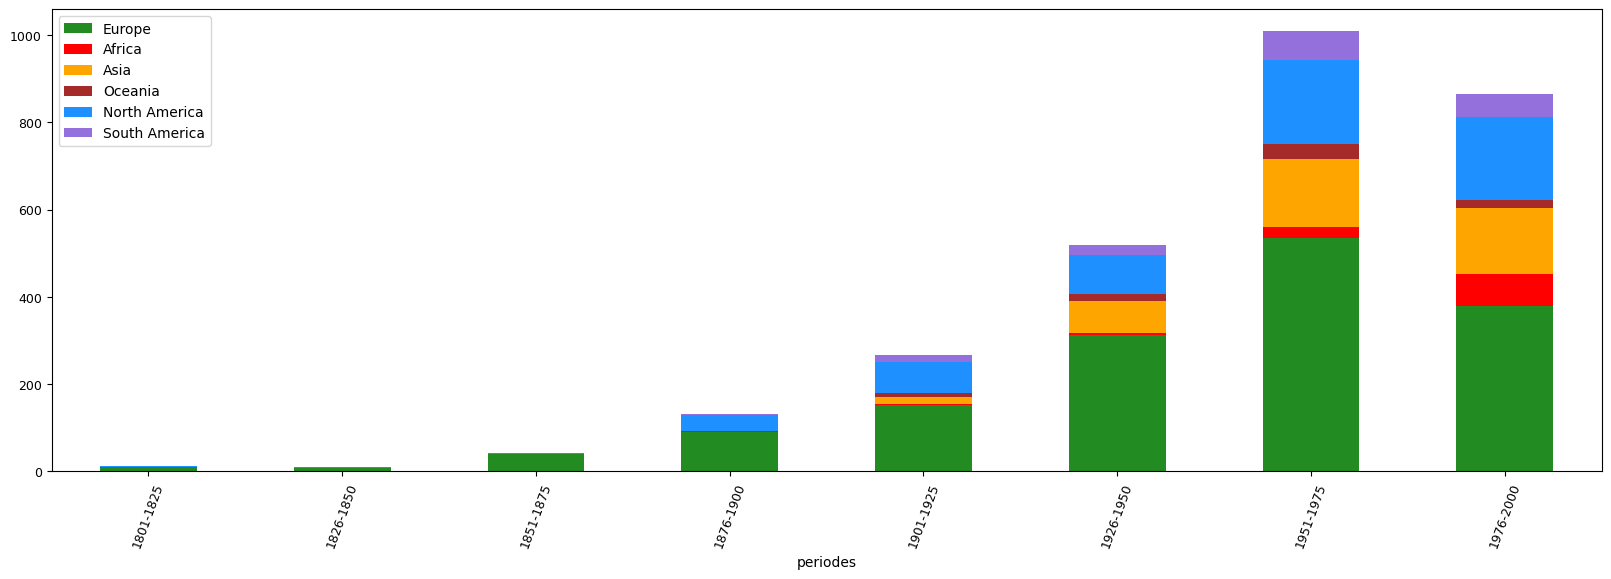

In [ ]:
### Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
ax = merged.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,6), color=['Forestgreen', 'Red', 'Orange','Brown','Dodgerblue', 'Mediumpurple'])
plt.show()

# Codage par période de dix ans

Comme on voit bien dans le graphique précédent les effectifs de la période allant de 1801 à 1850 sont très faibles et peu significatifs.On restraint donc la période analysée aux années 1850-2000 et on affine avec un découpage par périodes de dix ans

In [ ]:
l_10 = list(range(1891, 2010, 10))
l_10[:5],l_10[-5:]

([1891, 1901, 1911, 1921, 1931], [1961, 1971, 1981, 1991, 2001])

In [ ]:
### Découpage par décennies
## fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

df_p_first_continent['per_10'] = pd.cut(df_p_first_continent['birthYear'], l_10, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p_first_continent['per_10'] = df_p_first_continent['per_10'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p_first_continent.head(3)

,person_label,birthYear,nationalités,continents,l_nationalités,l_continents,length_l_occ,gender,periodes,first_continent,per_10
person_uri,,,,,,,,,,,
http://www.wikidata.org/entity/Q100324415,Estrella Rivas Franco,1921,spain,Europe,[spain],[Europe],1,F,1901-1925,Europe,1921-1930
http://www.wikidata.org/entity/Q100462257,Ina Trifonova,1981,bulgaria,Europe,[bulgaria],[Europe],1,F,1976-2000,Europe,1981-1990
http://www.wikidata.org/entity/Q101085725,Abbas Kaijuka,1989,uganda,Africa,[uganda],[Africa],1,M,1976-2000,Africa,1981-1990


In [ ]:
### Regrouper et compter avec un fitre sur le continent Europe
continent_e = pd.DataFrame(df_p_first_continent[df_p_first_continent.first_continent == 'Europe'].groupby('per_10').size())
continent_e.columns = ['europe']
continent_e.tail()


,europe
per_10,
1951-1960,167
1961-1970,240
1971-1980,256
1981-1990,195
1991-2000,57


In [ ]:
### Regrouper et compter avec un fitre sur le continent Afrique
continent_af = pd.DataFrame(df_p_first_continent[df_p_first_continent.first_continent == 'Africa'].groupby('per_10').size())
continent_af.columns = ['africa']
continent_af.tail()

,africa
per_10,
1951-1960,9
1961-1970,9
1971-1980,27
1981-1990,40
1991-2000,14


In [ ]:
### Regrouper et compter avec un fitre sur le continent Afrique
continent_as = pd.DataFrame(df_p_first_continent[df_p_first_continent.first_continent == 'Asia'].groupby('per_10').size())
continent_as.columns = ['asia']
continent_as.tail()

,asia
per_10,
1951-1960,50
1961-1970,60
1971-1980,86
1981-1990,80
1991-2000,30


In [ ]:
### Regrouper et compter avec un fitre sur le continent Océanie
continent_o = pd.DataFrame(df_p_first_continent[df_p_first_continent.first_continent == 'Oceania'].groupby('per_10').size())
continent_o.columns = ['oceania']
continent_o.tail()

,oceania
per_10,
1951-1960,11
1961-1970,16
1971-1980,14
1981-1990,10
1991-2000,1


In [ ]:
### Regrouper et compter avec un fitre sur le continent Amérique du Nord
continent_na = pd.DataFrame(df_p_first_continent[df_p_first_continent.first_continent == 'North America'].groupby('per_10').size())
continent_na.columns = ['north_america']
continent_na.tail()

,north_america
per_10,
1951-1960,52
1961-1970,94
1971-1980,96
1981-1990,104
1991-2000,36


In [ ]:
### Regrouper et compter avec un fitre sur le continent Amérique du Sud
continent_sa = pd.DataFrame(df_p_first_continent[df_p_first_continent.first_continent == 'South America'].groupby('per_10').size())
continent_sa.columns = ['south_america']
continent_sa.tail()

,south_america
per_10,
1951-1960,23
1961-1970,33
1971-1980,22
1981-1990,28
1991-2000,15


In [ ]:
dfs = [continent_e, continent_af, continent_as, continent_o, continent_na, continent_sa]
# Fusionner les DataFrames en utilisant l'index comme clé de jointure
merged = pd.merge(dfs[0], dfs[1], left_index=True, right_index=True)  # Utilisation des deux premiers DataFrames pour commencer la fusion

# Fusionner les DataFrames restants un par un
for df in dfs[2:]:
    merged = pd.merge(merged, df, left_index=True, right_index=True)
merged.tail()

,europe,africa,asia,oceania,north_america,south_america
per_10,,,,,,
1951-1960,167,9,50,11,52,23
1961-1970,240,9,60,16,94,33
1971-1980,256,27,86,14,96,22
1981-1990,195,40,80,10,104,28
1991-2000,57,14,30,1,36,15


In [ ]:
### On transforme le type de valeur de l'index
# et on ajoute une colonne avec le total
merged.index = merged.index.map(str)
merged['tot']=merged['europe']+merged['africa']+merged['asia']+merged['oceania']+merged['north_america']+merged['south_america']
merged.tail()

,europe,africa,asia,oceania,north_america,south_america,tot
per_10,,,,,,,
1951-1960,167,9,50,11,52,23,312
1961-1970,240,9,60,16,94,33,452
1971-1980,256,27,86,14,96,22,501
1981-1990,195,40,80,10,104,28,457
1991-2000,57,14,30,1,36,15,153


In [ ]:
### On prépare les valeurs pour l'affichage des fréquences (proportion par rapport au total)

# liste qui contient toutes les valeurs à la suite
m_f = merged.europe.to_list()+merged.africa.to_list()+merged.asia.to_list()+merged.oceania.to_list()+merged.north_america.to_list()+merged.south_america.to_list()

# liste d'égale longueur que la précédente qui contient
# les valeurs de l'index, i.e. les périodes
tot = merged.tot.to_list()*6

# liste qui contient les valeurs des fréquences
lp = [round(v/t, 2) for v,t in zip(m_f, tot)]
lp[:3]

[0.6, 0.57, 0.59]

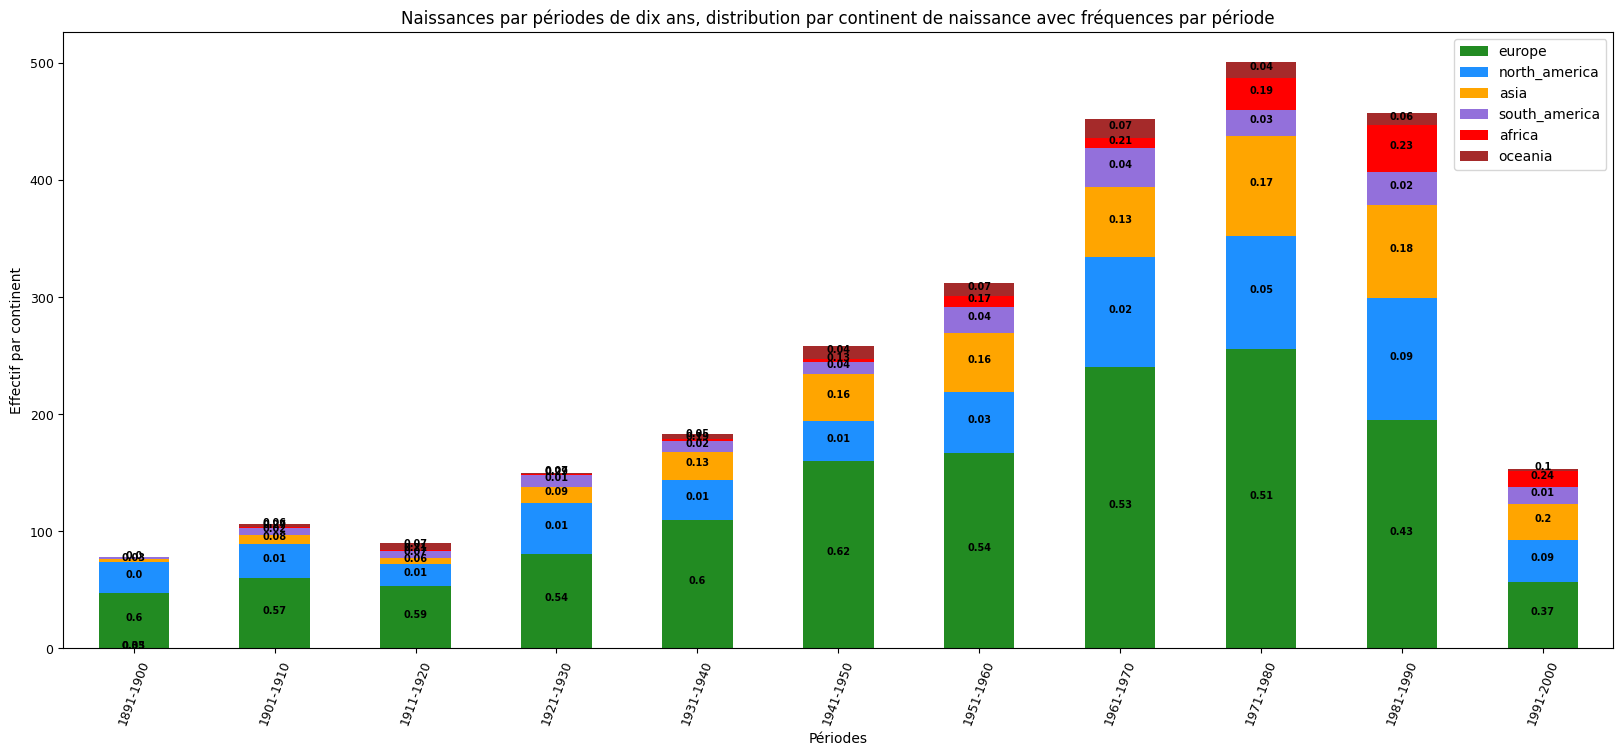

In [ ]:
import os

# Votre code pour générer le graphique
### Graphique avec la distribution par période et genre (M,F)


ax = merged.plot.bar(stacked=True, y=['europe','north_america','asia', 'south_america', 'africa', 'oceania'], \
                        rot=70, fontsize=9, figsize=(20,8), color=['Forestgreen', 'Dodgerblue', 'Orange', 'Mediumpurple', 'Red', 'Brown'])


### https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/


## On ajoute une étiquette concernant la valeur de fréquence
# à chaque rectangle dans le graphe, en utilisant la list 'lp' préparée précédemment
# Il y a autant de triangles que les valeurs d'index x le nombre de variables

for bar,v in zip(ax.patches,lp):

    ax.text(
      # Met les étiquette aux centre des rectangles
      bar.get_x() + bar.get_width() / 2,

      # Ajoute les coordonnées verticales
      bar.get_height()/2 + bar.get_y(),


      # Ajoute les valeurs
      v,

      # centre et met du style aux étiquettes
      ha='center',
      color='black',
      weight='bold',
      size=7
  )

plt.ylabel('Effectif par continent')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de dix ans, distribution par continent de naissance avec fréquences par période')

# Créer le répertoire s'il n'existe pas déjà
directory = 'images'
if not os.path.exists(directory):
    os.makedirs(directory)

# Sauvegarder l'image dans le répertoire
plt.savefig('images/naissances_distribution_10ans_continent.jpg', bbox_inches='tight', pad_inches=0.2)
plt.show()